# Time Series Prediction using LSTM

### Objective:
In this project, we used the Durham temperature record data from 1901 to 2019 to predict the average temperature in Durham in the year 2020. The data consists of daily readings of the maximum and the minimum temperature values. Using these values, the daily average temperature is calculated. The dataset is time-series data as the average temperature is measured over equal time intervals. We chose the LSTM to predict the daily average temperature for the year 2020 using the given historical data.

In [1]:
# Importing the relevant libraries 
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Read the Durham observatory data
data = pd.read_csv("durhamtemp_1901_2019.csv")

# Drop all the rows with null values
data.dropna(inplace=True)

# Print the information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43464 entries, 0 to 43463
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     43464 non-null  float64
 1   Month    43464 non-null  float64
 2   Day      43464 non-null  float64
 3   Date     43464 non-null  object 
 4   PPT.     43464 non-null  float64
 5   Av temp  43464 non-null  float64
 6   Tmax     43464 non-null  float64
 7   Tmin     43464 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.0+ MB


In [3]:
# Change the date format to datetime and sort the data by date
data['Date'] =  pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.sort_values('Date', inplace=True)

In [4]:
# Filter out the univariate time series data and store it in the variable named temperature 
temperature = data.loc[:,["Av temp"]]
temperature.columns = ["avg_temp"]
temperature.index = data["Date"]
# Quick summary of the data
temperature.describe()

,avg_temp
count,43464.000000
mean,8.722577
std,5.096972
min,-9.000000
25%,4.800000
50%,8.700000
75%,12.800000
max,24.400000


In [5]:
temperature

,avg_temp
Date,
1901-01-01,2.1
1901-01-02,4.0
1901-01-03,3.0
1901-01-04,3.7
1901-01-05,-0.3
...,...
2019-12-27,6.0
2019-12-28,7.8
2019-12-29,8.7


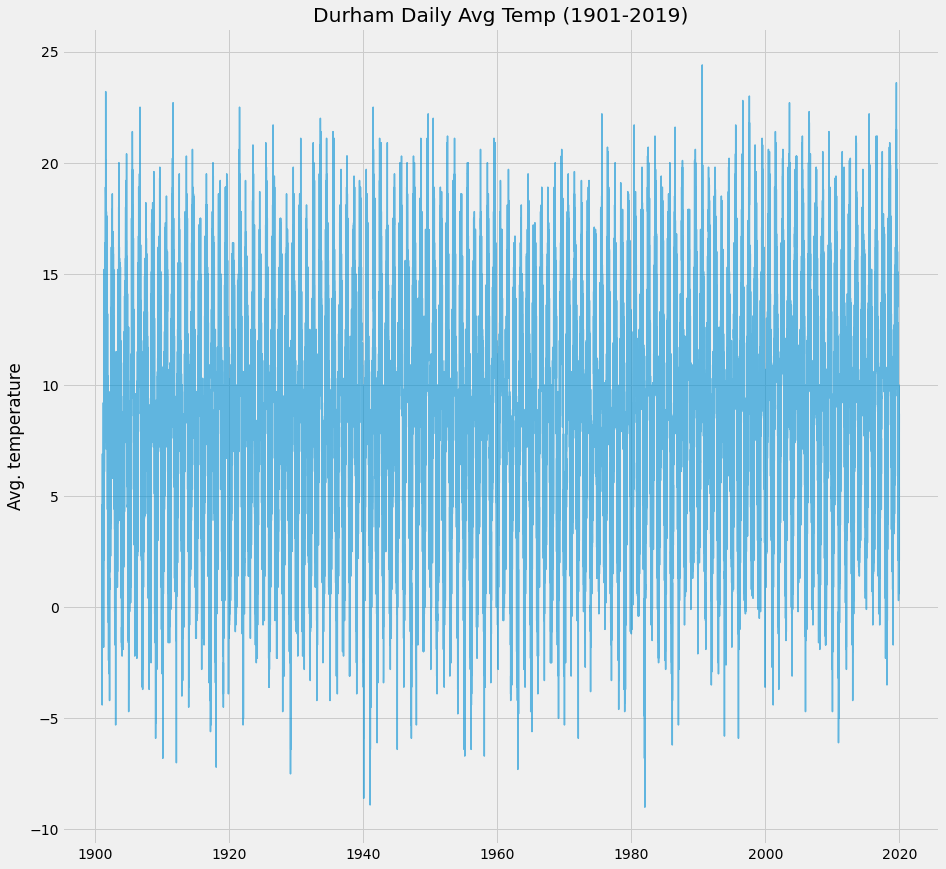

In [6]:
# Plot the time series data 
plt.figure(figsize=(14,14))
plt.plot(temperature, label="average temperature", linewidth=1.5, alpha=0.6)
plt.ylabel("Avg. temperature")
plt.title("Durham Daily Avg Temp (1901-2019)")
plt.show()

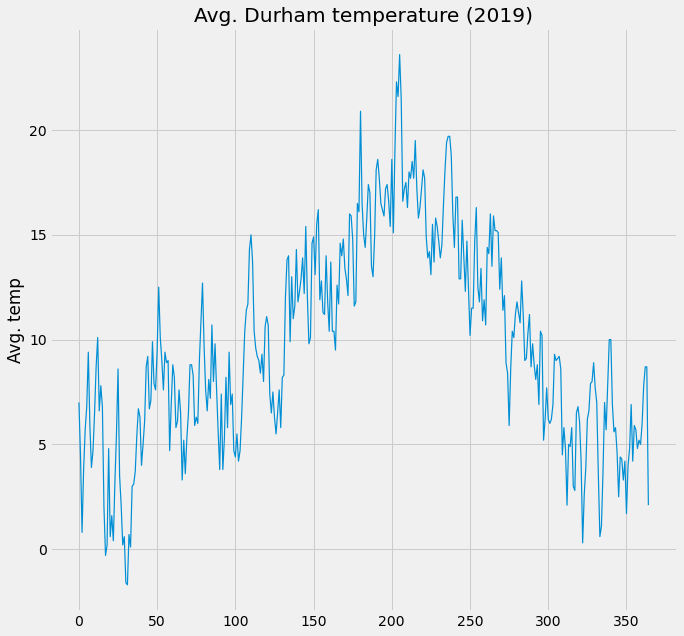

In [7]:
plt.figure(figsize=(10,10))
plt.plot(data[data["Year"] == 2019]["Av temp"].values, label="Avg temp (2019)", linewidth=1.2)
plt.ylabel("Avg. temp")
plt.title("Avg. Durham temperature (2019)")
plt.show()

In [8]:
# Get the values of the time series data
time_series = temperature["avg_temp"]
time_series

Date
1901-01-01    2.1
1901-01-02    4.0
1901-01-03    3.0
1901-01-04    3.7
1901-01-05   -0.3
             ... 
2019-12-27    6.0
2019-12-28    7.8
2019-12-29    8.7
2019-12-30    8.7
2019-12-31    2.1
Name: avg_temp, Length: 43464, dtype: float64

In [9]:
#   A function to create X and Y matrices from a time series list to train the LSTM model. 
def rolling_window(dataset, lag):
    
    X, Y = [], []

    for i in range(len(dataset) - lag):
        X.append(dataset[i:(i+lag)])
        Y.append(dataset[i+lag])
    
    X, Y = np.array(X), np.array(Y)
    X, Y = np.reshape(X, (X.shape[0], X.shape[1], 1)), np.reshape(Y, (Y.shape[0], 1))

    return X, Y

In [10]:
# Use window of 100 days to predict the temperature
lag = 100
x, y = rolling_window(time_series, lag=lag)

In [11]:
x.shape

(43364, 100, 1)

In [12]:
y.shape

(43364, 1)

### Split the dataset into train and the test set
About 85% of the data was set aside for the training process, and the rest 15%, was set for testing the data.

In [13]:
# 85% of the data is for training and 15% for testing our model
train_size = int(len(x) * 0.85)
test_size = len(x) - train_size

# Split the data into the train and test set
X_train = x[0:train_size]
Y_train = y[0:train_size]

X_test = x[train_size:len(x)]
Y_test = y[train_size:len(y)]

### Initializing the LSTM model

The model that we trained has one LSTM layer with 10, 25, and 50 hidden layers connected to
a linear layer that calculates the final output. 

In [14]:
# Number of layers in LSTM
epochs = 20
num_layers = 10

# Define the LSTM model
model_10 = Sequential()
model_10.add(LSTM(num_layers, activation='relu', input_shape=(lag, 1)))
model_10.add(Dense(1))

# Setting the optimizer and the loss function
model_10.compile(optimizer='adam', loss='mse')

model_10.summary()

# Training the model for 20 epochs


model_10.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=epochs,
    validation_data=(X_test, Y_test),
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1152/1152 [==============================] - 46s 39ms/step - loss: 23.4159 - val_loss: 5.4090
Epoch 2/20
1152/1152 [==============================] - 44s 38ms/step - loss: 4.6293 - val_loss: 4.3909
Epoch 3/20
1152/1152 [==============================] - 44s 38ms/step - loss: 4.2894 - val_loss: 4.2103
Epoch 4/20
1152/1152 [==============================] - 44s 38ms/step - loss: 4.3377 - val_loss: 4.1921
Epoch 5/20
1152/1152 [==============================] - 44s 38ms/step - loss: 4.0953 - val_loss: 4.0731

In [15]:
# Number of layers=25 in LSTM
epochs = 20
num_layers = 25

# Define the LSTM model
model_25 = Sequential()
model_25.add(LSTM(num_layers, activation='relu', input_shape=(lag, 1)))
model_25.add(Dense(1))

# Setting the optimizer and the loss function
model_25.compile(optimizer='adam', loss='mse')

model_25.summary()

model_25.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=epochs,
    validation_data=(X_test, Y_test),
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                2700      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1152/1152 [==============================] - 49s 42ms/step - loss: 44.8896 - val_loss: 4.5433
Epoch 2/20
1152/1152 [==============================] - 48s 42ms/step - loss: 4.2410 - val_loss: 7.0162
Epoch 3/20
1152/1152 [==============================] - 49s 43ms/step - loss: 4.0810 - val_loss: 3.9399
Epoch 4/20
1152/1152 [==============================] - 49s 43ms/step - loss: 3.8740 - val_loss: 3.9408
Epoch 5/20
1152/1152 [==============================] - 49s 43ms/step - loss: 3.8653 - val_loss: 

In [16]:
tf.random.set_seed(seed=42)

# Number of layers=50 in LSTM
epochs = 20
num_layers = 50

# Define the LSTM model
model_50 = Sequential()
model_50.add(LSTM(num_layers, activation='relu', input_shape=(lag, 1)))
model_50.add(Dense(1))

# Setting the optimizer and the loss function
model_50.compile(optimizer='adam', loss='mse')

model_50.summary()

model_50.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=epochs,
    validation_data=(X_test, Y_test),
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1152/1152 [==============================] - 61s 52ms/step - loss: 26.8362 - val_loss: 3.8558
Epoch 2/20
1152/1152 [==============================] - 60s 52ms/step - loss: 3.7986 - val_loss: 3.8666
Epoch 3/20
1152/1152 [==============================] - 60s 52ms/step - loss: 3.7873 - val_loss: 3.9156
Epoch 4/20
1152/1152 [==============================] - 60s 52ms/step - loss: 3.7587 - val_loss: 3.7319
Epoch 5/20
1152/1152 [==============================] - 60s 52ms/step - loss: 3.7494 - val_loss

In [17]:
#model_50 = keras.models.load_model("my_model")

### Test set predictions 

Comparing the different models, we found that the
model with 50 hidden layers performs the best on the test set. We used a 100-day rolling window to calculate the average temperature on the 101st day. 

In [18]:
# Store the predictions the lstm model makes on the test set
def prediction_test(model, X_test):
    return [y[0] for y in model.predict(X_test)]
    
y_pred = prediction_test(model_50, X_test)

In [19]:
y_pred

[6.5335994,
 6.307239,
 5.094509,
 4.343122,
 5.4109664,
 5.2773623,
 9.463627,
 7.6061125,
 7.5644145,
 8.320039,
 8.518867,
 10.4578905,
 8.173557,
 7.00764,
 7.4829574,
 7.001837,
 7.163105,
 8.171708,
 6.9658313,
 7.9948735,
 10.419665,
 10.578739,
 10.665898,
 7.30026,
 9.147953,
 10.805506,
 8.700553,
 8.134141,
 4.9531054,
 7.100604,
 7.5880795,
 8.150501,
 5.636644,
 7.991476,
 6.436293,
 7.2182245,
 8.30287,
 6.551966,
 8.538926,
 9.731708,
 8.452865,
 9.406233,
 11.493503,
 12.316137,
 12.202518,
 12.488817,
 11.94703,
 10.99028,
 9.022023,
 8.788808,
 7.7444015,
 9.180624,
 9.414032,
 8.4262495,
 9.556728,
 8.364419,
 7.924352,
 10.579713,
 9.41241,
 10.523919,
 9.676445,
 10.076809,
 12.574735,
 9.629373,
 12.39839,
 11.016136,
 11.971286,
 12.97196,
 15.19387,
 11.74038,
 11.622959,
 13.918052,
 13.068683,
 14.337774,
 13.340867,
 12.453208,
 12.284059,
 12.156545,
 10.92984,
 12.762206,
 12.619569,
 11.612625,
 11.495977,
 12.009947,
 15.0131035,
 14.327772,
 11.498324,
 

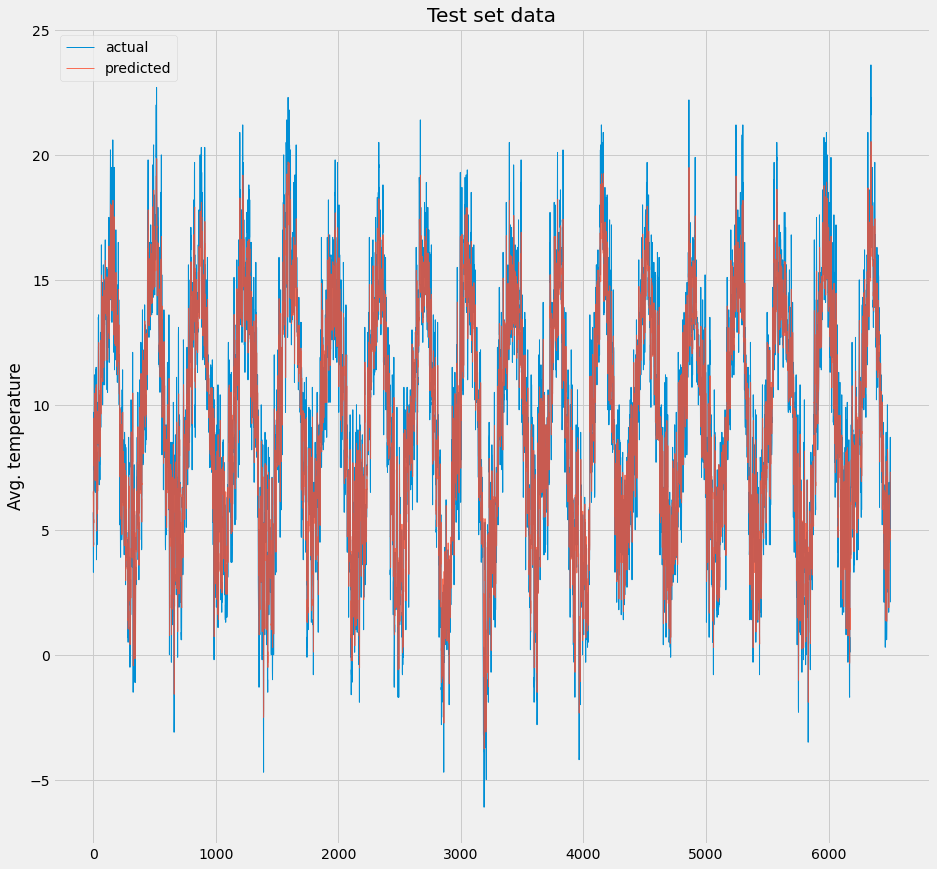

In [20]:
# Plot the test-set and the predictions on the test-set
plt.figure(figsize=(14,14))
plt.plot(Y_test, label="actual", linewidth=1)
plt.plot(y_pred, label="predicted", linewidth=1, alpha=0.8)
plt.ylabel("Avg. temperature")
plt.title("Test set data")
plt.legend()
plt.show()

In [21]:
# Function to predict n steps ahead

def predict_nsteps(model, dataset, nsteps, lag):
  
    X = dataset[-lag:].values.reshape(-1,1)
    X = np.reshape(X, (1, X.shape[0], 1))

    # Making the prediction list 
    yhat = []

    for _ in range(nsteps):

        prediction = model.predict(X)
        yhat.append(prediction)

        X = np.append(X, prediction)
        X = np.delete(X, 0)
        X = np.reshape(X, (1, len(X), 1))

    return yhat 

In [22]:
# Predict the weather for the next year
nsteps = 365
n_ahead = predict_nsteps(model=model_50, dataset=time_series, nsteps=nsteps, lag=lag)

In [23]:
y_ahead = [y[0][0] for y in n_ahead]

In [24]:
y_ahead

[1.7171519,
 2.639815,
 3.2667603,
 3.4578483,
 3.5699227,
 3.6792202,
 3.8564916,
 3.9093678,
 3.8469677,
 3.7611113,
 3.6893902,
 3.630773,
 3.5859568,
 3.5607312,
 3.5926178,
 3.7319462,
 3.9459398,
 4.155888,
 4.3504233,
 4.5448084,
 4.747543,
 4.950327,
 5.140434,
 5.320187,
 5.4892187,
 5.6306443,
 5.7594824,
 5.889723,
 6.0269303,
 6.177956,
 6.3160443,
 6.4374037,
 6.5506816,
 6.638048,
 6.6999207,
 6.7532806,
 6.8139963,
 6.8896923,
 6.9804134,
 7.0882077,
 7.2189302,
 7.3640475,
 7.5167804,
 7.669312,
 7.820826,
 7.955718,
 8.078463,
 8.193749,
 8.301902,
 8.40593,
 8.5052805,
 8.60785,
 8.712424,
 8.820277,
 8.944091,
 9.05801,
 9.1512375,
 9.239074,
 9.330112,
 9.4287195,
 9.539196,
 9.66513,
 9.805584,
 9.965672,
 10.139287,
 10.318746,
 10.476346,
 10.600838,
 10.713797,
 10.822641,
 10.932235,
 11.057428,
 11.21496,
 11.388093,
 11.572777,
 11.754499,
 11.911212,
 12.04631,
 12.166714,
 12.277404,
 12.382243,
 12.483613,
 12.581878,
 12.676519,
 12.768346,
 12.857838,
 1

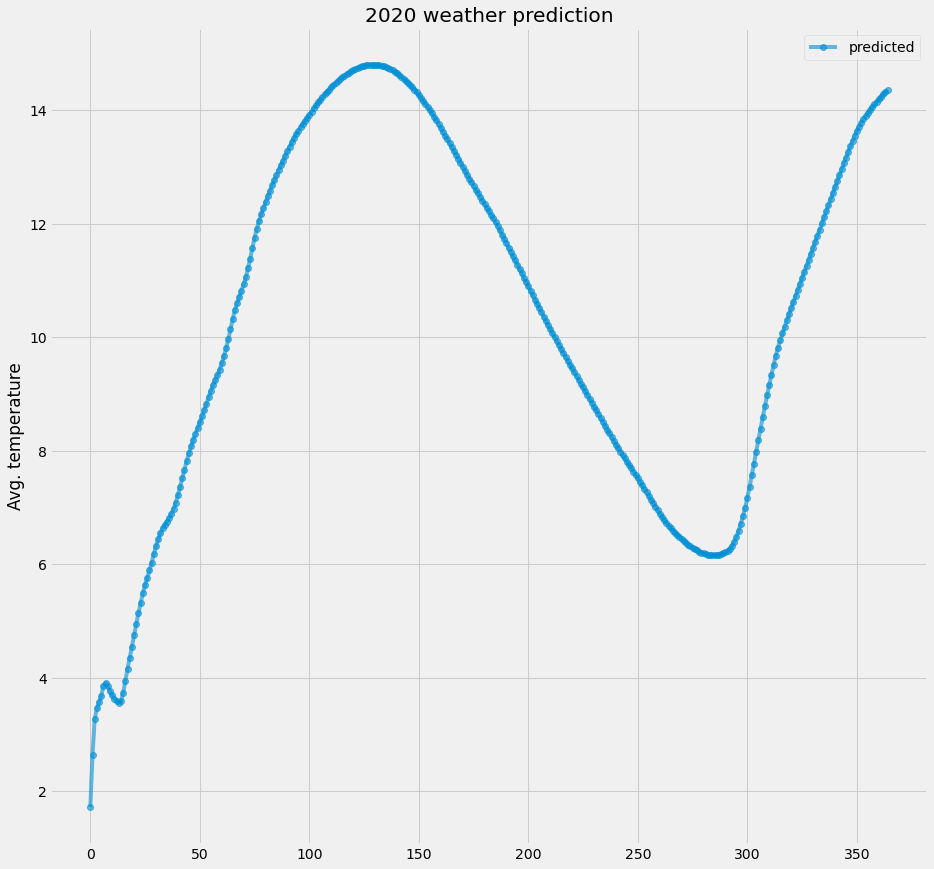

In [25]:
plt.figure(figsize=(14,14))
plt.plot(y_ahead, label="predicted", alpha=0.6, marker='o')
plt.ylabel("Avg. temperature")
plt.title("2020 weather prediction")
plt.legend()
plt.show()

### Conclusion 
The above plot depicts the 2020 Durham daily weather prediction. We observe an increasing average temperature for the first 125 days of 2020, after which the temperature falls before rising again. We expected to see a dip in the average temperature for the last 100-120 days of 2020. However, since we are using a rolling window of only a hundred days to make the prediction, the LSTM model is unable to learn the yearly trend of the data. LSTMs are not good at learning long term trends. This problem can be circumvented by increasing the size of the rolling window. 